In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt
import numpy as np
import yaml
import joblib
import os

seed=456

In [2]:
##  Extracting data
with open("../config.yaml", "r") as f:
    config = yaml.safe_load(f)

model_path = config["model"]["path"]
output_path = config["output"]["path"]

train_df = pd.read_csv(config["data"]["processed_train_path"])
test_df = pd.read_csv(config["data"]["processed_test_path"])

# Define our features (X) and target (y)
features = [col for col in train_df.columns if col not in ['battle_id', 'player_won']]
X_train = train_df[features]
X_test=test_df[features]
y_train = train_df['player_won']
#print(features)




In [ ]:
variances = X_train.var()
low_variance = variances[variances < 1e-2].index
X_train.drop(columns = low_variance)
X_test.drop(columns = low_variance)



,p1_mean_base_hp,p1_min_base_hp,p1_max_base_hp,p1_std_base_hp,p1_mean_base_atk,p1_min_base_atk,p1_max_base_atk,p1_std_base_atk,p1_mean_base_def,p1_min_base_def,...,p1_attack_moves,p2_attack_moves,p1_status_moves,p2_status_moves,p1_same_type_moves_number,p2_same_type_moves_number,p1_effectivness_avg,p2_effectivness_avg,p1_supereffective_moves_count,p2_supereffective_moves_count
0,129.166667,65,250,62.942875,76.666667,5,110,34.960295,65.000000,5,...,21,18,4,6,10,15,1.285714,1.111111,6,20
1,119.166667,55,250,67.045797,78.333333,5,110,38.586123,70.833333,5,...,23,9,1,16,12,5,0.913043,1.222222,4,11
2,80.000000,55,105,18.257419,90.000000,50,130,24.324199,85.833333,45,...,13,19,5,4,1,11,0.923077,0.947368,4,18
3,124.166667,60,250,64.382753,85.833333,5,130,39.729991,75.833333,5,...,6,23,16,2,4,10,0.666667,0.913043,1,21
4,92.500000,60,160,33.757715,92.500000,50,130,25.454207,80.833333,35,...,11,19,13,6,6,0,0.636364,1.105263,0,21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,85.000000,50,160,36.285902,92.500000,50,110,20.361320,100.000000,45,...,17,15,8,6,15,14,1.000000,1.133333,0,17
4996,116.666667,55,250,68.718427,68.333333,5,110,36.817870,55.000000,5,...,13,17,13,7,3,4,0.923077,1.000000,4,17
4997,102.666667,55,250,66.849749,78.166667,5,134,42.467308,71.666667,5,...,24,24,2,3,3,17,0.958333,0.958333,1,23
4998,121.666667,60,250,65.362239,79.166667,5,110,34.810998,70.000000,5,...,8,20,4,8,6,13,0.875000,0.900000,0,18


## Logistic Regression

In [78]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score


# Scaling all the data
scaler=StandardScaler()
scaler.fit(X_train)
X_train=scaler.transform(X_train)
X_test = scaler.transform(X_test)

model = LogisticRegression(random_state=seed)

param_grid = {
#    'C': [0.001, 0.01, 0.1, 1, 10, 100,],      decomment for every change of dataset
    'C': [0.105,0.11,0.115],           ## comment if u change the dataset
    'penalty': ['l2'],
    'solver': ['liblinear', 'saga'],
    'max_iter': [10000]
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1,
    return_train_score= True
)

grid_search.fit(X_train, y_train)
best_index = grid_search.best_index_
mean_acc = grid_search.cv_results_['mean_test_score'][best_index]
std_acc = grid_search.cv_results_['std_test_score'][best_index]

print(f" Best model mean validation accuracy: {mean_acc:.4f}")
print(f" Standard deviation across validation folds: {std_acc:.4f}")
print("Best hyperparameters found:", grid_search.best_params_)
print(f"Best accuracy in CV: {grid_search.best_score_:.4f}")


best_model = grid_search.best_estimator_


Fitting 5 folds for each of 6 candidates, totalling 30 fits
 Best model mean validation accuracy: 0.8076
 Standard deviation across validation folds: 0.0077
Best hyperparameters found: {'C': 0.11, 'max_iter': 10000, 'penalty': 'l2', 'solver': 'saga'}
Best accuracy in CV: 0.8076


## KNN V1

In [75]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score


# Scaling all the data
scaler=StandardScaler()
scaler.fit(X_train)
X_train=scaler.transform(X_train)
X_test = scaler.transform(X_test)

model = KNeighborsClassifier()

k_range = list(range(60,200,20))

param_grid = {
    'n_neighbors': k_range,           ## comment if u change the dataset
    'weights': ['uniform', 'distance'],
    'metric': ['minkowski', 'manhattan'],
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=3,
    return_train_score= True
)

grid_search.fit(X_train, y_train)
best_index = grid_search.best_index_
mean_acc = grid_search.cv_results_['mean_test_score'][best_index]
std_acc = grid_search.cv_results_['std_test_score'][best_index]

print(f" Best model mean validation accuracy: {mean_acc:.4f}")
print(f" Standard deviation across validation folds: {std_acc:.4f}")
print("Best hyperparameters found:", grid_search.best_params_)
print(f"Best accuracy in CV: {grid_search.best_score_:.4f}")


best_model = grid_search.best_estimator_

Fitting 5 folds for each of 28 candidates, totalling 140 fits
 Best model mean validation accuracy: 0.7737
 Standard deviation across validation folds: 0.0117
Best hyperparameters found: {'metric': 'minkowski', 'n_neighbors': 120, 'weights': 'distance'}
Best accuracy in CV: 0.7737


# KNN V2

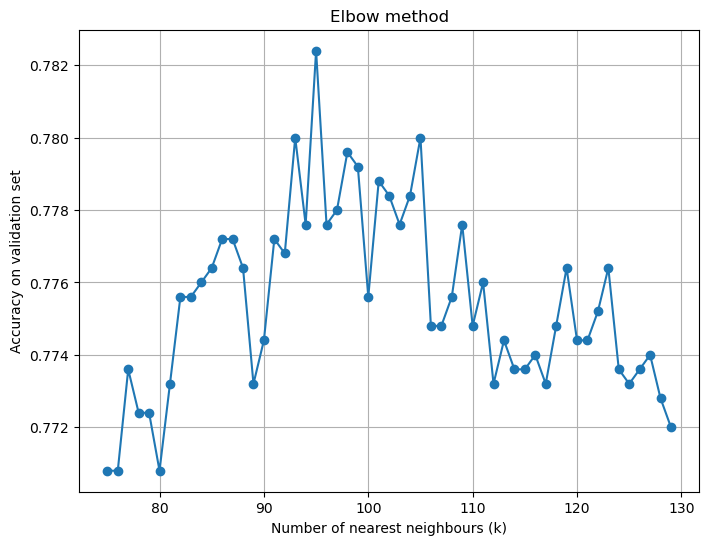

Best k: 95
Accuracy for validation set: 0.7824
Kfold with optimal k:
Mean of accuracy in folds: 0.7673
Stddev of accuracy in folds: 0.0076


KNeighborsClassifier(n_neighbors=95)

In [76]:
### This is the KNN classifier
# an important thing is that we have a lot of feature and, in order to reduce dimensionality we can apply pca
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold, cross_val_score
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings("ignore", message="Could not find the number of physical cores")

# Hyperparameters
k_values = range(75, 130)   # testiamo k da 1 a 30
n_splits = 5              # 5-fold cross-validation

# applying PCA for reduction of dimensionality and scaling the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_tr_elb, X_val_elb, y_tr_elb, y_val_elb= train_test_split(X_train, y_train, test_size=0.25,random_state=seed, shuffle=True)



# building elbow method
accuracies=[]
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_tr_elb, y_tr_elb)
    y_pred = knn.predict(X_val_elb)
    acc = accuracy_score(y_val_elb, y_pred)
    accuracies.append(acc)

# plot elbow
plt.figure(figsize=(8,6))
plt.plot(k_values, accuracies, marker='o')
plt.title("Elbow method")
plt.xlabel("Number of nearest neighbours (k)")
plt.ylabel("Accuracy on validation set")
plt.grid(True)
plt.show()


# Best k
best_k = k_values[np.argmax(accuracies)]
print(f"Best k: {best_k}")
print(f"Accuracy for validation set: {max(accuracies):.4f}")

# Kfold with the best k
kf = KFold(n_splits=5, shuffle=True, random_state=seed)
best_knn = KNeighborsClassifier(n_neighbors=best_k)

cv_scores = cross_val_score(best_knn, X_train, y_train, cv=kf, scoring='accuracy')

print("Kfold with optimal k:")
print(f"Mean of accuracy in folds: {cv_scores.mean():.4f}")
print(f"Stddev of accuracy in folds: {cv_scores.std():.4f}")

# Last training with all the data
best_model = KNeighborsClassifier(n_neighbors=best_k)
best_model.fit(X_train, y_train)


# DECISION TREES


In [3]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold, cross_val_score


# No need to scale the data

model = DecisionTreeClassifier(random_state=seed)

k_range = list(range(60,200,20))

param_grid = {
    'criterion': ['gini', 'entropy', 'log_loss'], # impurity function to minimize
    'max_depth': [None, 3, 5, 10, 20, 30], # max_depth of the tree
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=3,
    return_train_score= True
)

grid_search.fit(X_train, y_train)
best_index = grid_search.best_index_
mean_acc = grid_search.cv_results_['mean_test_score'][best_index]
std_acc = grid_search.cv_results_['std_test_score'][best_index]

print(f" Best model mean validation accuracy: {mean_acc:.4f}")
print(f" Standard deviation across validation folds: {std_acc:.4f}")
print("Best hyperparameters found:", grid_search.best_params_)
print(f"Best accuracy in CV: {grid_search.best_score_:.4f}")


best_model = grid_search.best_estimator_

Fitting 5 folds for each of 18 candidates, totalling 90 fits
 Best model mean validation accuracy: 0.7696
 Standard deviation across validation folds: 0.0083
Best hyperparameters found: {'criterion': 'gini', 'max_depth': 5}
Best accuracy in CV: 0.7696


# RANDOM FOREST

In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, cross_val_score
# Random Forest
rforest = RandomForestClassifier(
    criterion='log_loss',
    max_depth=10,
    n_estimators=300,
    random_state=seed
)

# K-Fold cross-validation (k=5)
kfold = KFold(n_splits=5, shuffle=True, random_state=seed)

# Calcolo dell’accuracy media con cross-validation
scores = cross_val_score(rforest, X_train, y_train, cv=kfold, scoring='accuracy')

print("Accuracy per fold:", np.round(scores, 3))
print(f"Accuracy in mean +- stddev: {scores.mean():.3f} ± {scores.std():.3f}")


Accuracy per fold: [0.795 0.816 0.796 0.824 0.796]
Accuracy in mean +- stddev: 0.805 ± 0.012


# XGBOOST


In [ ]:
pip install xgboost
from xgboost import XGBClassifier
from sklearn.model_selection import KFold, cross_val_score
import numpy as np

# Modello XGBoost
xgb = XGBClassifier(
    n_estimators=300,        # numero di alberi
    max_depth=6,            # profondità massima degli alberi
    learning_rate=0.1,      # tasso di apprendimento
    subsample=0.8,          # frazione di dati per ogni albero
    colsample_bytree=0.8,   # frazione di feature per albero
    random_state=seed,
    use_label_encoder=False,
    eval_metric='logloss'   # evita warning
)

# K-Fold cross-validation
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Accuracy media
scores = cross_val_score(xgb, X, y, cv=kfold, scoring='accuracy')

print("Accuratezze per fold:", np.round(scores, 3))
print(f"Accuracy media XGBoost: {scores.mean():.3f} ± {scores.std():.3f}")


SyntaxError: invalid syntax (756843254.py, line 1)

# SUBMISSIONS


In [66]:
# Testing the prediction on the test set

print("Generating predictions on the test set...")
test_predictions = best_model.predict(X_test)

Generating predictions on the test set...


In [67]:

# Create the submission DataFrame
submission_df = pd.DataFrame({
    'battle_id': test_df['battle_id'],
    'player_won': test_predictions
})
# Save the DataFrame to a .csv file
submission_df.to_csv(output_path, index=False)

print("\n'submission.csv' file created successfully!")


'submission.csv' file created successfully!
